In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from utils.checkpoints import load_checkpoint, save_checkpoint
from utils.display import display_images
from utils.benchmark import train

In [3]:
from torch.utils.data import Dataset
from __datasets__ import VINSDataset


class VINSGanDataset(Dataset):
    def __init__(self, dataset: "VINSDataset", size=(64, 64)):
        self.dataset = dataset
        self.size = size

    def __getitem__(self, item):
        if isinstance(item, slice):
            return {
                "image1": torch.stack([self.dataset[i]["image"] for i in range(item.start, item.stop)]),
                "image2": torch.stack([self.dataset[i]["image"] for i in range(item.start, item.stop)]),
            }
        out = self.dataset[item]
        image1 = out["image"]
        bboxes = out["bboxes"]
        bbox = bboxes[torch.randint(len(bboxes), (1,))]
        image2 = image1.clone()
        image2[:, bbox[1]:bbox[3], bbox[0]:bbox[2]] = -1
        return {
            "image1": T.Resize(self.size, antialias=False)(image1),
            "image2": T.Resize(self.size, antialias=False)(image2),
        }

    def __len__(self):
        return len(self.dataset)


ds = VINSGanDataset(
    VINSDataset(DIR="./../../pytorch/datasets/vins",
                SET="Android",
                download=True,
                sub_sample=1,
                image_transform=T.Compose([
                    T.ToTensor(),
                    lambda x: x.to("mps"),
                ])),
    size=(512, 512),
)
len(ds)

740

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


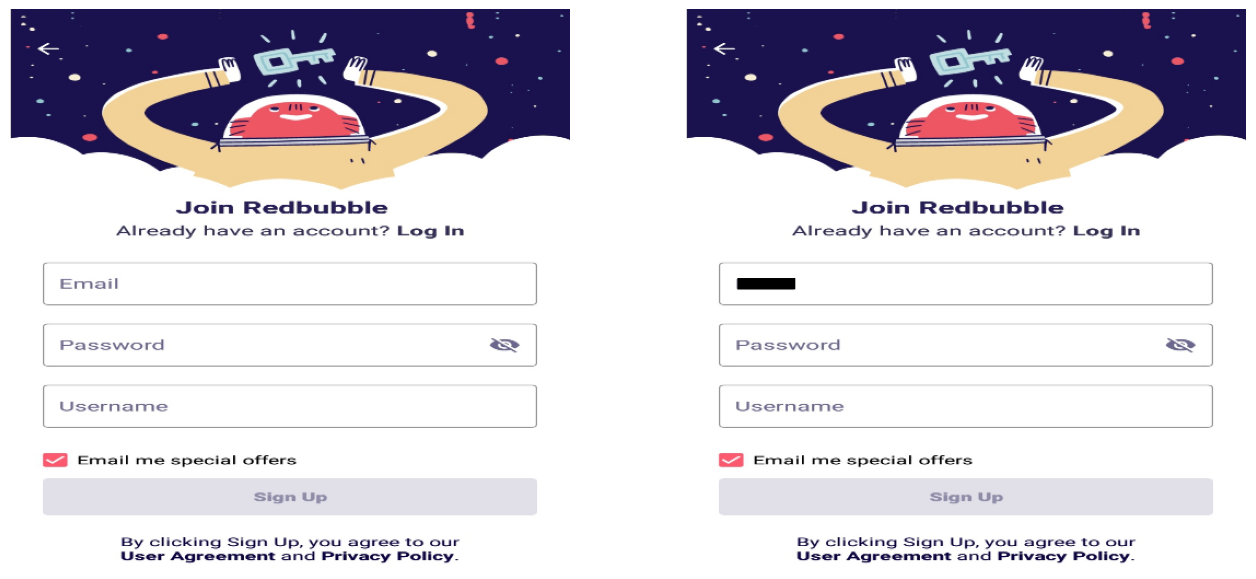

In [4]:
display_images([
    ds[i := torch.randint(0, len(ds), (1,)).item()]["image1"].cpu().permute(1, 2, 0),
    ds[i]["image2"].cpu().permute(1, 2, 0),
])

In [5]:
from new import ResGenerator, PatchDiscriminator

generator = ResGenerator(
    inp_chn=3,
    out_chn=3,
    hid_chn=64,
    act=nn.ReLU,
    norm=nn.InstanceNorm2d,
    n=1,
    p=0,
    sampling=2,
    residuals=5,
).to("mps")
discriminator = PatchDiscriminator(
    inp_chn=3,
    blocks=4,
    act=nn.ReLU,
    norm=nn.InstanceNorm2d,
    n=1,
    p=0,
    m_block=64,
).to("mps")
optimizerG = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [6]:
generator

ResGenerator(
  (head): ConvBlock(
    (layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (blocks): SkipBlock(
    (encoder): ModuleList(
      (0): ConvBlock(
        (layers): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU()
        )
      )
      (1): ConvBlock(
        (layers): ModuleList(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU()
        )
      )
    )
    (bottleneck): Sequential(
      (0): ResidualConvBlock(
        (layers): ModuleList(
      

In [7]:
discriminator

PatchDiscriminator(
  (head): ConvBlock(
    (layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (main): Sequential(
    (0): ConvBlock(
      (layers): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (layers): ModuleList(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
      )
    )
    (2): ConvBlock(
      (layers): ModuleList(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()


In [8]:
from new.train_step import build_gan_trainer
from new.loss_step import kl_loss_step

def data_extractor(DATA):
    return DATA["image1"], DATA["image2"]


fixed_inp = ds[0:9]["image1"], ds[0:9]["image2"]
trainer = build_gan_trainer(
    generator,
    discriminator,
    optimizerG,
    optimizerD,
    kl_loss_step,
    data_extractor,
    device="mps",
    fixed_inp=fixed_inp,
)

In [48]:
generator = generator.train()
discriminator = discriminator.train()
step_offset = train(
    trainer, ds,
    ne=2, bs=1,
    step_offset=0,
)
step_offset

Epoch: 0/2 | Batch 0/740|          |  0% [00:00<?, ?it/s ]

KeyboardInterrupt: 

In [ ]:
with torch.inference_mode():
    generator = generator.eval()
    discriminator = discriminator.eval()
    inp = ds[torch.randint(0, len(ds), (1,)).item()]
    display_images([
        inp["image2"].cpu().permute(1, 2, 0),
        generator(inp["image2"][None]).cpu().squeeze(0).permute(1, 2, 0),
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


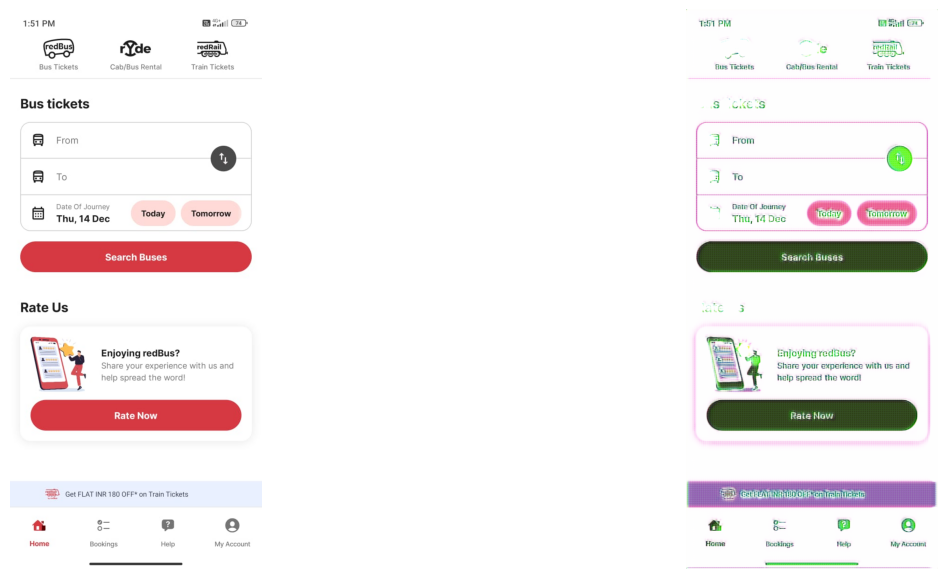

In [56]:
from torchvision.io import read_image

imgTest = (read_image("img.jpeg") / 255).to("mps")
with torch.inference_mode():
    generator = generator.eval()
    discriminator = discriminator.eval()
    display_images([
        imgTest.cpu().permute(1, 2, 0),
        generator(imgTest[None]).cpu().squeeze(0).permute(1, 2, 0),
    ])